# Import Statements
For required libraries.

In [1]:
# Import statements
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Model
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3

2023-06-14 03:48:47.046972: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 03:48:47.104378: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 03:48:47.107874: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 03:48:48.472414: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Check dataset proportions
By looking at the number of items.

In [2]:
# Dataset Directories for Fauna
TRAINING_DIR = "./datasets/flora/train"
VALIDATION_DIR = "./datasets/flora/val"

# Fauna Labels
FLORA_LABELS = next(os.walk(TRAINING_DIR))[1]
FLORA_LABELS.sort()
print(FLORA_LABELS)

['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

Observing the first three animal images.

Flora: Apple Braeburn
Training images: 492
Validation images: 164
Sample Apple Braeburn image:


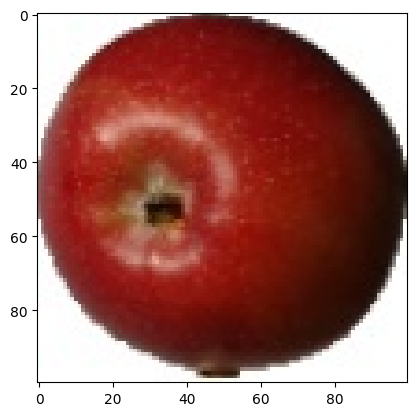


Flora: Apple Crimson Snow
Training images: 444
Validation images: 148
Sample Apple Crimson Snow image:


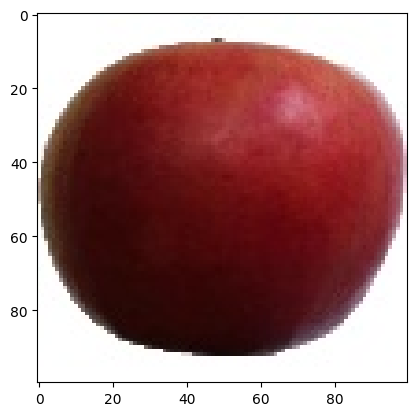


Flora: Apple Golden 1
Training images: 480
Validation images: 160
Sample Apple Golden 1 image:


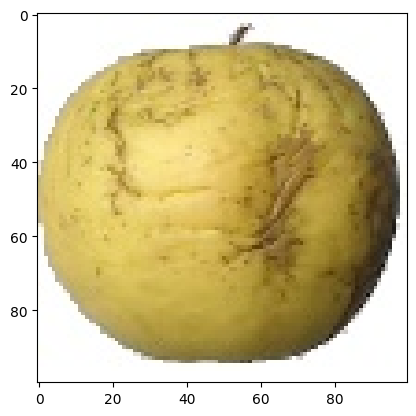

In [3]:
for flora in FLORA_LABELS[0:3]:
    # preparing directories
    train_flora_dir = os.path.join(TRAINING_DIR, flora)
    val_flora_dir = os.path.join(VALIDATION_DIR, flora)
    # displaying the results
    print(f"Flora: {flora}")
    print(f"Training images: {len(os.listdir(train_flora_dir))}")
    print(f"Validation images: {len(os.listdir(val_flora_dir))}")
    print(f"Sample {flora} image:")
    plt.imshow(load_img(f"{os.path.join(train_flora_dir, os.listdir(train_flora_dir)[0])}"))
    plt.show()
    print()

# Preprocessing the dataset
By using TensorFlow's ImageDataGenerator.

Create dataset generators, and augment the training dataset.

In [4]:
def train_val_generators(train_dir, valid_dir, image_size):
    # Train dataset will be augmented as follows
    train_datagen = ImageDataGenerator(rescale=1./255)
                                        # rotation_range=40,
                                        # width_shift_range=0.2,
                                        # height_shift_range=0.2,
                                        # shear_range=0.2,
                                        # zoom_range=0.2,
                                        # horizontal_flip=True,
                                        # vertical_flip=False,
                                        # fill_mode='nearest')
    # Initialize training generator
    train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                        batch_size=64, 
                                                        class_mode='categorical',
                                                        target_size=(image_size, image_size))
    
    # Validation dataset will not be augmented 
    validation_datagen = ImageDataGenerator(rescale=1./255)
    # Initialize validation generator
    validation_generator = validation_datagen.flow_from_directory(directory=valid_dir,
                                                                    batch_size=64, 
                                                                    class_mode='categorical',
                                                                    target_size=(image_size, image_size))
    return train_generator, validation_generator

In [5]:
IMAGE_SIZE = 100
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, IMAGE_SIZE)

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


# Model
Create a model using transfer learning.

## InceptionV3
Model creation.

Download weights.

In [6]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-14 03:50:09--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.167.128, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  88.4MB/s    in 0.9s    

2023-06-14 03:50:10 (88.4 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Initialize InceptionV3

In [7]:
def create_inception_base_model(local_weights_file):
    pre_trained_model = InceptionV3(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
                                    include_top = False, 
                                    weights = None) 
    pre_trained_model.load_weights(local_weights_file)

    for layer in pre_trained_model.layers:
        layer.trainable = False
    
    return pre_trained_model

In [8]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
inception_base_model = create_inception_base_model(local_weights_file)

In [9]:
def output_of_last_layer(inception_base_model):
    last_desired_layer = inception_base_model.get_layer('mixed7')
    print('last layer output shape: ', last_desired_layer.output_shape)
    last_output = last_desired_layer.output
    print('last layer output: ', last_output)
    return last_output

inception_last_layer = output_of_last_layer(inception_base_model)

last layer output shape:  (None, 4, 4, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [10]:
def create_final_model(pre_trained_model, last_output):
  x = layers.Flatten()(last_output)

  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.2)(x) 
  x = layers.Dense(131, activation='softmax')(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  
  return model

In [11]:
model = create_final_model(inception_base_model, inception_last_layer)
# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,693,475 total parameters in this model.
There are 12,718,211 trainable parameters in this model.


Callback class.

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

## Model Training and Evaluation

In [14]:
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=validation_generator,
                    callbacks=[callbacks])

Epoch 1/20
2023-06-14 03:51:16.477904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
1058/1058 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.96532023-06-14 04:15:10.435305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
1058/1058 [==============================] - 1813s 2s/step - loss: 0.1815 - accuracy: 0.9653 - val_loss: 0.1576 - val_accuracy: 0.9634
Epoch 2/20
1058/1058 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 0.9997
Reached 99% accura

## Model Plotting

Text(0.5, 1.0, 'Training and validation loss')

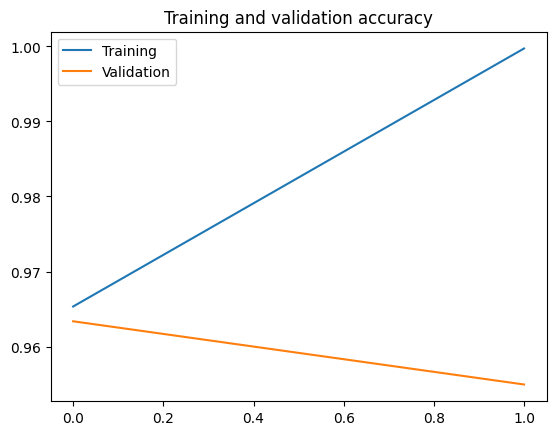

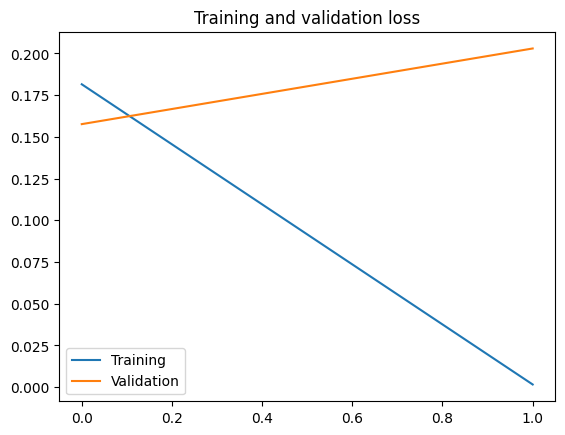

In [15]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

## Model Saving
As Keras HDF5 file.

In [16]:
import time
curr_time = int(time.time())
saved_model_path = f"./models/flora/{curr_time}-inception_model.h5"

model.save(saved_model_path)
model.save(saved_model_path[:-3])

2023-06-14 04:51:50.651153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-06-14 04:51:58.390537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
INFO:tensorflow:Assets written to: ./models/flora/1686718301-inception_model/assets
INFO:tensorflow:Assets written to: ./models/flora/1686718301-inception_model/assets
